In [2]:
# import module
import os
import sys

import dowhy
import econml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import shap
import statsmodels.nonparametric.smoothers_lowess as sl
from econml.grf import CausalForest, CausalIVForest, RegressionForest
from econml.iv.dml import DMLIV, NonParamDMLIV, OrthoIV
from econml.iv.dr import DRIV, ForestDRIV, LinearDRIV, SparseLinearDRIV
from econml.sklearn_extensions.linear_model import WeightedLassoCV
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy import special
from scipy.interpolate import interp1d, interpn
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import (LinearRegression, LogisticRegression,
                                  LogisticRegressionCV)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.stats.multitest import multipletests

/home/yujia/miniconda3/envs/mr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def warn(*args, **kwargs):
    pass
import warnings

warnings.warn = warn

In [4]:
# load dataset and sample
X_set1 = pd.read_csv("/home/yujia/Project/2023-07-20-individual_MR/dat/04_pheno_covar_data/traits/ukbb.covariate.traits.set1.gz", sep = "\t")
X_set2 = pd.read_csv("/home/yujia/Project/2023-07-20-individual_MR/dat/04_pheno_covar_data/traits/ukbb.covariate.traits.set2.gz", sep = "\t")
X_set3 = pd.read_csv("/home/yujia/Project/2023-07-20-individual_MR/dat/04_pheno_covar_data/TC/CAD/ukbb.covariate.TC.set3.gz", sep = "\t")

Z_set1 = pd.read_csv("/home/yujia/Project/2023-07-20-individual_MR/dat/06_PRS_calculation/TC/CAD/set1/1e-08/TC_prs.best", sep = " ") # score_constd
Z_set2 = pd.read_csv("/home/yujia/Project/2023-07-20-individual_MR/dat/06_PRS_calculation/TC/CAD/set2/1e-08/TC_prs.best", sep = " ") # score_constd
Z_set3 = pd.read_csv("/home/yujia/Project/2023-07-20-individual_MR/dat/06_PRS_calculation/TC/CAD/set3/1e-08/TC_prs.best", sep = " ") # score_constd

W = pd.read_csv("~/Project/2023-07-20-individual_MR/dat/04_pheno_covar_data/TC/CAD/ukbb.phenotype.TC.mgdL", sep = "\t")

Y_date1 = pd.read_csv("~/Project/2023-07-20-individual_MR/dat/03_outcome_data/CAD_outcome_include_comorbid_date1_james2022.gz", sep = "\t")
Y_date2 = pd.read_csv("~/Project/2023-07-20-individual_MR/dat/03_outcome_data/CAD_outcome_include_comorbid_date2_james2022.gz", sep = "\t")
Y_date3 = pd.read_csv("~/Project/2023-07-20-individual_MR/dat/03_outcome_data/CAD_outcome_include_comorbid_date3_james2022.gz", sep = "\t")

# harmonize the data
selected_id_set1 = set.intersection(set(X_set1['IID']), set(Z_set1['IID']), set(W['IID']), set(Y_date1['IID']) )
selected_id_set2 = set.intersection(set(X_set2['IID']), set(Z_set2['IID']), set(W['IID']), set(Y_date2['IID']) )
selected_id_set3 = set.intersection(set(X_set3['IID']), set(Z_set3['IID']), set(W['IID']), set(Y_date3['IID']) )
selected_id_set1 = list(selected_id_set1)
selected_id_set2 = list(selected_id_set2)
selected_id_set3 = list(selected_id_set3)
selected_id_set1_arr = np.array(selected_id_set1)
selected_id_set2_arr = np.array(selected_id_set2)
selected_id_set3_arr = np.array(selected_id_set3)
selected_id_set1_arr.sort()
selected_id_set2_arr.sort()
selected_id_set3_arr.sort()

selected_id_set1b = set.intersection(set(X_set1['IID']), set(Z_set1['IID']), set(W['IID']), set(Y_date3['IID']) )
selected_id_set2b = set.intersection(set(X_set2['IID']), set(Z_set2['IID']), set(W['IID']), set(Y_date3['IID']) )
selected_id_set1b = list(selected_id_set1b)
selected_id_set2b = list(selected_id_set2b)
selected_id_set1b_arr = np.array(selected_id_set1b)
selected_id_set2b_arr = np.array(selected_id_set2b)
selected_id_set1b_arr.sort()
selected_id_set2b_arr.sort()

# model 1
X_model1 = X_set1.loc[X_set1['IID'].isin(selected_id_set1)].reset_index(drop = True)
Z_model1 = Z_set1.loc[Z_set1['IID'].isin(selected_id_set1)].reset_index(drop = True)
W_model1 = W.loc[W['IID'].isin(selected_id_set1)].reset_index(drop = True)
Y_model1 = Y_date1.loc[Y_date1['IID'].isin(selected_id_set1)].reset_index(drop = True)

# model 1b
X_model1b = X_set1.loc[X_set1['IID'].isin(selected_id_set1b)].reset_index(drop = True)
Z_model1b = Z_set1.loc[Z_set1['IID'].isin(selected_id_set1b)].reset_index(drop = True)
W_model1b = W.loc[W['IID'].isin(selected_id_set1b)].reset_index(drop = True)
Y_model1b = Y_date3.loc[Y_date3['IID'].isin(selected_id_set1b)].reset_index(drop = True)

# model 2
X_model2 = X_set2.loc[X_set2['IID'].isin(selected_id_set2)].reset_index(drop = True)
Z_model2 = Z_set2.loc[Z_set2['IID'].isin(selected_id_set2)].reset_index(drop = True)
W_model2 = W.loc[W['IID'].isin(selected_id_set2)].reset_index(drop = True)
Y_model2 = Y_date2.loc[Y_date2['IID'].isin(selected_id_set2)].reset_index(drop = True)
X_model2 = pd.concat([X_model2, Y_model2.loc[:, ["htn", "t2dm", "heart_failure", "hemorrhage_stroke", "ischemic_stroke"]]], axis=1)
Y_model2 = Y_model2.loc[:, ["IID", "CAD"]]

# model 2b
X_model2b = X_set2.loc[X_set2['IID'].isin(selected_id_set2b)].reset_index(drop = True)
Z_model2b = Z_set2.loc[Z_set2['IID'].isin(selected_id_set2b)].reset_index(drop = True)
W_model2b = W.loc[W['IID'].isin(selected_id_set2b)].reset_index(drop = True)
Y_model2b = Y_date3.loc[Y_date3['IID'].isin(selected_id_set2b)].reset_index(drop = True)
X_model2b = pd.concat([X_model2b, Y_model2b.loc[:, ["htn", "t2dm", "heart_failure", "hemorrhage_stroke", "ischemic_stroke"]]], axis=1)
Y_model2b = Y_model2b.loc[:, ["IID", "CAD"]]

# model 3
X_model3 = X_set3.loc[X_set3['IID'].isin(selected_id_set3)].reset_index(drop = True)
Z_model3 = Z_set3.loc[Z_set3['IID'].isin(selected_id_set3)].reset_index(drop = True)
W_model3 = W.loc[W['IID'].isin(selected_id_set3)].reset_index(drop = True)
Y_model3 = Y_date3.loc[Y_date3['IID'].isin(selected_id_set3)].reset_index(drop = True)
X_model3 = pd.concat([X_model3, Y_model3.loc[:, ["htn", "t2dm", "heart_failure", "hemorrhage_stroke", "ischemic_stroke"]]], axis=1)
Y_model3 = Y_model3.loc[:, ["IID", "CAD"]]

# generate mat file for three models
# model 1
W_model1_mat = W_model1.loc[:, ["30690-0.0"]]["30690-0.0"]
X_model1_mat = X_model1.iloc[:, 2:]
Y_model1_mat = Y_model1.loc[:, ["CAD"]]["CAD"]
Z_model1_mat = Z_model1.iloc[:, 3]

# model 1b
W_model1b_mat = W_model1b.loc[:, ["30690-0.0"]]["30690-0.0"]
X_model1b_mat = X_model1b.iloc[:, 2:]
Y_model1b_mat = Y_model1b.loc[:, ["CAD"]]["CAD"]
Z_model1b_mat = Z_model1b.iloc[:, 3]

# model 2
W_model2_mat = W_model2.loc[:, ["30690-0.0"]]["30690-0.0"]
X_model2_mat = X_model2.iloc[:, 2:]
Y_model2_mat = Y_model2.loc[:, ["CAD"]]["CAD"]
Z_model2_mat = Z_model2.iloc[:, 3]

# model 2b
W_model2b_mat = W_model2b.loc[:, ["30690-0.0"]]["30690-0.0"]
X_model2b_mat = X_model2b.iloc[:, 2:]
Y_model2b_mat = Y_model2b.loc[:, ["CAD"]]["CAD"]
Z_model2b_mat = Z_model2b.iloc[:, 3]

# model 3
W_model3_mat = W_model3.loc[:, ["30690-0.0"]]["30690-0.0"]
X_model3_mat = X_model3.iloc[:, 2:]
Y_model3_mat = Y_model3.loc[:, ["CAD"]]["CAD"]
Z_model3_mat = Z_model3.iloc[:, 3]

# correct the data type
X_model1_mat = X_model1_mat.astype({
    "22001-0.0": 'int64', "21022-0.0": 'float64', "22000-0.0": 'float64',
    "22009-0.1": 'float64', "22009-0.2": 'float64', "22009-0.3": 'float64', "22009-0.4": 'float64', "22009-0.5": 'float64',
    "22009-0.6": 'float64', "22009-0.7": 'float64', "22009-0.8": 'float64', "22009-0.9": 'float64', "22009-0.10": 'float64',
})

X_model1b_mat = X_model1b_mat.astype({
    "22001-0.0": 'int64', "21022-0.0": 'float64', "22000-0.0": 'float64',
    "22009-0.1": 'float64', "22009-0.2": 'float64', "22009-0.3": 'float64', "22009-0.4": 'float64', "22009-0.5": 'float64',
    "22009-0.6": 'float64', "22009-0.7": 'float64', "22009-0.8": 'float64', "22009-0.9": 'float64', "22009-0.10": 'float64',
})

X_model2_mat = X_model2_mat.astype({
    "22001-0.0": 'int64', "21022-0.0": 'float64', 
    "4079-0.0": 'float64', "4080-0.0": 'float64', "189-0.0": 'float64', 
    "22009-0.1": 'float64', "22009-0.2": 'float64', "22009-0.3": 'float64', "22009-0.4": 'float64', "22009-0.5": 'float64',
    "22009-0.6": 'float64', "22009-0.7": 'float64', "22009-0.8": 'float64', "22009-0.9": 'float64', "22009-0.10": 'float64', "22000-0.0": 'float64',
    "whr": 'float64', "23099-0.0": 'float64', "21001-0.0": 'float64', "21002-0.0": 'float64',
    "Blood_pressure_medication": 'int64', "Cholesterol_lowering_medication": 'int64', "No_medication": 'int64', "Insulin": 'int64', 
    "Non_alcohol_drinker": 'int64' , "Previous_alcohol_drinker": 'int64', "Current_alcohol_drinker": 'int64',
    "Non_smoker": 'int64' , "Previous_smoker": 'int64', "Current_smoker": 'int64'
})

X_model2b_mat = X_model2b_mat.astype({
    "22001-0.0": 'int64', "21022-0.0": 'float64', 
    "4079-0.0": 'float64', "4080-0.0": 'float64', "189-0.0": 'float64', 
    "22009-0.1": 'float64', "22009-0.2": 'float64', "22009-0.3": 'float64', "22009-0.4": 'float64', "22009-0.5": 'float64',
    "22009-0.6": 'float64', "22009-0.7": 'float64', "22009-0.8": 'float64', "22009-0.9": 'float64', "22009-0.10": 'float64', "22000-0.0": 'float64',
    "whr": 'float64', "23099-0.0": 'float64', "21001-0.0": 'float64', "21002-0.0": 'float64',
    "Blood_pressure_medication": 'int64', "Cholesterol_lowering_medication": 'int64', "No_medication": 'int64', "Insulin": 'int64', 
    "Non_alcohol_drinker": 'int64' , "Previous_alcohol_drinker": 'int64', "Current_alcohol_drinker": 'int64',
    "Non_smoker": 'int64' , "Previous_smoker": 'int64', "Current_smoker": 'int64'
})

X_model3_mat = X_model3_mat.astype({
    "22001-0.0": 'int64', "21022-0.0": 'float64', 
    "4079-0.0": 'float64', "4080-0.0": 'float64', "189-0.0": 'float64', 
    "22009-0.1": 'float64', "22009-0.2": 'float64', "22009-0.3": 'float64', "22009-0.4": 'float64', "22009-0.5": 'float64',
    "22009-0.6": 'float64', "22009-0.7": 'float64', "22009-0.8": 'float64', "22009-0.9": 'float64', "22009-0.10": 'float64', "22000-0.0": 'float64',
    "whr": 'float64', "23099-0.0": 'float64', "21001-0.0": 'float64', "21002-0.0": 'float64',
    "Blood_pressure_medication": 'int64', "Cholesterol_lowering_medication": 'int64', "No_medication": 'int64', "Insulin": 'int64', 
    "Non_alcohol_drinker": 'int64' , "Previous_alcohol_drinker": 'int64', "Current_alcohol_drinker": 'int64',
    "Non_smoker": 'int64' , "Previous_smoker": 'int64', "Current_smoker": 'int64',
    "30870-0.0": 'float64', # lipid-related covariates
    "30680-0.0": 'float64', "30700-0.0": 'float64', "30710-0.0": 'float64', "30720-0.0": 'float64', "30730-0.0": 'float64', 
    "30740-0.0": 'float64', "30750-0.0": 'float64', "30650-0.0": 'float64', "30660-0.0": 'float64', 
    "30670-0.0": 'float64', "30770-0.0": 'float64', "30810-0.0": 'float64', "30830-0.0": 'float64', "30850-0.0": 'float64', 
    "30860-0.0": 'float64', "30880-0.0": 'float64', "30890-0.0": 'float64', "30840-0.0": 'float64',
    "t2dm": 'int64', "htn": 'int64', "heart_failure": 'int64', "hemorrhage_stroke": 'int64', "ischemic_stroke": 'int64'
})

# correct the data type
X_model1_mat.rename({
    "22001-0.0": 'Gender', "21022-0.0": 'Age',
    "22009-0.1": 'PC1', "22009-0.2": 'PC2', "22009-0.3": 'PC3', "22009-0.4": 'PC4', "22009-0.5": 'PC5',
    "22009-0.6": 'PC6', "22009-0.7": 'PC7', "22009-0.8": 'PC8', "22009-0.9": 'PC9', "22009-0.10": 'PC10', "22000-0.0": 'Genotype batch',
}, inplace=True)

X_model1b_mat.rename({
    "22001-0.0": 'Gender', "21022-0.0": 'Age',
    "22009-0.1": 'PC1', "22009-0.2": 'PC2', "22009-0.3": 'PC3', "22009-0.4": 'PC4', "22009-0.5": 'PC5',
    "22009-0.6": 'PC6', "22009-0.7": 'PC7', "22009-0.8": 'PC8', "22009-0.9": 'PC9', "22009-0.10": 'PC10', "22000-0.0": 'Genotype batch',
}, inplace=True)

X_model2_mat.rename({
    "22001-0.0": 'Gender', "21022-0.0": 'Age', 
    "4079-0.0": 'diastolic blood pressure', "4080-0.0": 'systolic blood pressure', "189-0.0": 'Townsend deprivation index', 
    "22009-0.1": 'PC1', "22009-0.2": 'PC2', "22009-0.3": 'PC3', "22009-0.4": 'PC4', "22009-0.5": 'PC5',
    "22009-0.6": 'PC6', "22009-0.7": 'PC7', "22009-0.8": 'PC8', "22009-0.9": 'PC9', "22009-0.10": 'PC10', "22000-0.0": 'Genotype batch',
    "whr": 'Waist-hip-ratio', "23099-0.0": 'Body Fat Percentage', "21001-0.0": 'BMI', "21002-0.0": 'Weight',
    "Blood_pressure_medication": 'Blood pressure medication', "Cholesterol_lowering_medication": 'Cholesterol lowering medication', "No_medication": 'No medication', "Insulin": 'Insulin', 
    "Non_alcohol_drinker": 'Non-alcohol drinker' , "Previous_alcohol_drinker": 'Previous alcohol drinker', "Current_alcohol_drinker": 'Current alcohol drinker',
    "Non_smoker": 'Non-smoker' , "Previous_smoker": 'Previous smoker', "Current_smoker": 'Current smoker'
}, inplace=True)

X_model2b_mat.rename({
    "22001-0.0": 'Gender', "21022-0.0": 'Age', 
    "4079-0.0": 'diastolic blood pressure', "4080-0.0": 'systolic blood pressure', "189-0.0": 'Townsend deprivation index', 
    "22009-0.1": 'PC1', "22009-0.2": 'PC2', "22009-0.3": 'PC3', "22009-0.4": 'PC4', "22009-0.5": 'PC5',
    "22009-0.6": 'PC6', "22009-0.7": 'PC7', "22009-0.8": 'PC8', "22009-0.9": 'PC9', "22009-0.10": 'PC10', "22000-0.0": 'Genotype batch',
    "whr": 'Waist-hip-ratio', "23099-0.0": 'Body Fat Percentage', "21001-0.0": 'BMI', "21002-0.0": 'Weight',
    "Blood_pressure_medication": 'Blood pressure medication', "Cholesterol_lowering_medication": 'Cholesterol lowering medication', "No_medication": 'No medication', "Insulin": 'Insulin', 
    "Non_alcohol_drinker": 'Non-alcohol drinker' , "Previous_alcohol_drinker": 'Previous alcohol drinker', "Current_alcohol_drinker": 'Current alcohol drinker',
    "Non_smoker": 'Non-smoker' , "Previous_smoker": 'Previous smoker', "Current_smoker": 'Current smoker'
}, inplace=True)

X_model3_mat.rename({
    "22001-0.0": 'Gender', "21022-0.0": 'Age', 
    "4079-0.0": 'diastolic blood pressure', "4080-0.0": 'systolic blood pressure', "189-0.0": 'Townsend deprivation index', 
    "22009-0.1": 'PC1', "22009-0.2": 'PC2', "22009-0.3": 'PC3', "22009-0.4": 'PC4', "22009-0.5": 'PC5',
    "22009-0.6": 'PC6', "22009-0.7": 'PC7', "22009-0.8": 'PC8', "22009-0.9": 'PC9', "22009-0.10": 'PC10', "22000-0.0": 'Genotype batch',
    "whr": 'Waist-hip-ratio', "23099-0.0": 'Body Fat Percentage', "21001-0.0": 'BMI', "21002-0.0": 'Weight',
    "Blood_pressure_medication": 'Blood pressure medication', "Cholesterol_lowering_medication": 'Cholesterol lowering medication', "No_medication": 'No medication', "Insulin": 'Insulin', 
    "Non_alcohol_drinker": 'Non-alcohol drinker' , "Previous_alcohol_drinker": 'Previous alcohol drinker', "Current_alcohol_drinker": 'Current alcohol drinker',
    "Non_smoker": 'Non-smoker' , "Previous_smoker": 'Previous smoker', "Current_smoker": 'Current smoker',
    "30870-0.0": 'Triglycerides', # lipid-related covariates
    "30680-0.0": 'Calcium', "30700-0.0": 'Creatinine', "30710-0.0": 'C-reactive protein', "30720-0.0": 'Cystatin C', "30730-0.0": 'Gamma glutamyltransferase', 
    "30740-0.0": 'Glucose', "30750-0.0": 'HbA1c', "30650-0.0": 'Aspartate aminotransferase', "30660-0.0": 'Direct bilirubin', 
    "30670-0.0": 'Urea', "30770-0.0": '30770-0.0', "30810-0.0": '30810-0.0', "30830-0.0": 'SHBG', "30850-0.0": 'Testosterone', 
    "30860-0.0": 'Total protein', "30880-0.0": 'Urate', "30890-0.0": 'Vitamin D', "30840-0.0": 'Total bilirubin',
    "t2dm": 'Type 2 diabetes history', "htn": 'Hypertension history', "heart_failure": 'Heart failure history', "hemorrhage_stroke": 'Hemorrhage Stroke history', "ischemic_stroke": 'Ischemic Stroke history'
}, inplace=True)

W_model1_mat_binary = np.where(W_model1_mat <= 220, 1, 0)
W_model1_mat_binary = pd.DataFrame({"30690-0.0": W_model1_mat_binary}).iloc[:, 0]
W_model1b_mat_binary = np.where(W_model1b_mat <= 220, 1, 0)
W_model1b_mat_binary = pd.DataFrame({"30690-0.0": W_model1b_mat_binary}).iloc[:, 0]
W_model2_mat_binary = np.where(W_model2_mat <= 220, 1, 0)
W_model2_mat_binary = pd.DataFrame({"30690-0.0": W_model2_mat_binary}).iloc[:, 0]
W_model2b_mat_binary = np.where(W_model2b_mat <= 220, 1, 0)
W_model2b_mat_binary = pd.DataFrame({"30690-0.0": W_model2b_mat_binary}).iloc[:, 0]
W_model3_mat_binary = np.where(W_model3_mat <= 220, 1, 0)
W_model3_mat_binary = pd.DataFrame({"30690-0.0": W_model3_mat_binary}).iloc[:, 0]

Z_model1_mat_binary = np.where(Z_model1_mat <= 0, 1, 0)
Z_model1_mat_binary = pd.DataFrame({"PRS": Z_model1_mat_binary}).iloc[:, 0]
Z_model1b_mat_binary = np.where(Z_model1b_mat <= 0, 1, 0)
Z_model1b_mat_binary = pd.DataFrame({"PRS": Z_model1b_mat_binary}).iloc[:, 0]
Z_model2_mat_binary = np.where(Z_model2_mat <= 0, 1, 0)
Z_model2_mat_binary = pd.DataFrame({"PRS": Z_model2_mat_binary}).iloc[:, 0]
Z_model2b_mat_binary = np.where(Z_model2b_mat <= 0, 1, 0)
Z_model2b_mat_binary = pd.DataFrame({"PRS": Z_model2b_mat_binary}).iloc[:, 0]
Z_model3_mat_binary = np.where(Z_model3_mat <= 0, 1, 0)
Z_model3_mat_binary = pd.DataFrame({"PRS": Z_model3_mat_binary}).iloc[:, 0]

#### DRIV estimator

#### Model 1

In [5]:
# split the dataset into training and testing
train, test = train_test_split(X_model1_mat, test_size=0.5, stratify=Y_model1_mat, random_state=309)
train_set = train.index.to_list()
test_set = test.index.to_list()
train_set.sort()
train_set.sort()
test_set.sort()

# write the training set and testing set to file, which will be used in R analysis.
train_set_pd = pd.DataFrame({"Training_index": [x+1 for x in train_set], "Training_id": selected_id_set1_arr[train_set]})
test_set_pd = pd.DataFrame({"Testing_index": [x+1 for x in test_set], "Testing_id": selected_id_set1_arr[test_set]})

In [6]:
# Continuous W (Training/Testing Set)
est_driv_train_continuousW = ForestDRIV(projection=False, discrete_treatment=False, discrete_instrument=False, \
                                        n_estimators=5000, min_samples_leaf=50, max_samples=0.02, 
                                        random_state=309, cov_clip = 1, n_jobs=15)
est_driv_train_continuousW.fit(Y_model1_mat[train_set], W_model1_mat[train_set], Z=Z_model1_mat[train_set], X=X_model1_mat.loc[train_set])
point_driv_test_continuousW = est_driv_train_continuousW.effect(X_model1_mat.loc[test_set])
point_driv_train_continuousW = est_driv_train_continuousW.effect(X_model1_mat.loc[train_set]) 
print(pd.DataFrame({"dat": point_driv_train_continuousW}).describe())
print(pd.DataFrame({"dat": point_driv_test_continuousW}).describe())

                 dat
count  160118.000000
mean        0.001392
std         0.000435
min         0.000513
25%         0.001072
50%         0.001248
75%         0.001647
max         0.003011
                 dat
count  160118.000000
mean        0.001392
std         0.000434
min         0.000501
25%         0.001072
50%         0.001249
75%         0.001648
max         0.002986


In [7]:
# Continuous W (Full Set)
est_driv_continuousW_model1 = ForestDRIV(projection=False, discrete_treatment=False, discrete_instrument=False, \
                                         n_estimators=5000, min_samples_leaf=100, max_samples=0.02, 
                                         random_state=309, n_jobs=15) 
est_driv_continuousW_model1.fit(Y_model1_mat, W_model1_mat, Z=Z_model1_mat, X=X_model1_mat, cache_values=True)
point_driv_continuousW_model1 = est_driv_continuousW_model1.effect(X_model1_mat)
print(pd.DataFrame({"dat": point_driv_continuousW_model1}).describe())

                 dat
count  320236.000000
mean        0.001246
std         0.000333
min         0.000428
25%         0.000989
50%         0.001151
75%         0.001476
max         0.002433


In [8]:
# Continuous W (Full Set)
est_driv_continuousW_model2 = ForestDRIV(projection=False, discrete_treatment=False, discrete_instrument=False, \
                                         n_estimators=5000, min_samples_leaf=100, max_samples=0.02, 
                                         random_state=309, cov_clip = 10, n_jobs=15) 
est_driv_continuousW_model2.fit(Y_model2_mat, W_model2_mat, Z=Z_model2_mat, X=X_model2_mat, cache_values=True)
point_driv_continuousW_model2 = est_driv_continuousW_model2.effect(X_model2_mat)
print(pd.DataFrame({"dat": point_driv_continuousW_model2}).describe())

                 dat
count  293038.000000
mean        0.000322
std         0.000061
min         0.000042
25%         0.000284
50%         0.000325
75%         0.000364
max         0.000566


In [5]:
# Continuous W (Full Set)
est_driv_continuousW_model3 = ForestDRIV(projection=False, discrete_treatment=False, discrete_instrument=False, \
                                  n_estimators=5000, min_samples_leaf=150, max_samples=0.02, 
                                  random_state=309, cov_clip = 10, n_jobs=15) 
est_driv_continuousW_model3.fit(Y_model3_mat, W_model3_mat, Z=Z_model3_mat, X=X_model3_mat, cache_values=True)
point_driv_continuousW_model3 = est_driv_continuousW_model3.effect(X_model3_mat)
print(pd.DataFrame({"dat": point_driv_continuousW_model3}).describe())

                 dat
count  276054.000000
mean        0.000200
std         0.000044
min        -0.000013
25%         0.000171
50%         0.000203
75%         0.000231
max         0.000355


(array([3.0000e+00, 6.0000e+00, 1.8000e+01, 5.1000e+01, 1.3300e+02,
        3.0700e+02, 6.6200e+02, 1.3260e+03, 2.2220e+03, 3.7240e+03,
        5.6080e+03, 8.1850e+03, 1.1362e+04, 1.5309e+04, 1.9640e+04,
        2.4023e+04, 2.7395e+04, 3.0091e+04, 3.0878e+04, 2.8556e+04,
        2.4128e+04, 1.7912e+04, 1.1888e+04, 6.8640e+03, 3.4750e+03,
        1.5680e+03, 4.9900e+02, 1.8200e+02, 3.1000e+01, 8.0000e+00]),
 array([-1.31876747e-05, -9.19789254e-07,  1.13480962e-05,  2.36159817e-05,
         3.58838672e-05,  4.81517527e-05,  6.04196381e-05,  7.26875236e-05,
         8.49554091e-05,  9.72232946e-05,  1.09491180e-04,  1.21759066e-04,
         1.34026951e-04,  1.46294836e-04,  1.58562722e-04,  1.70830607e-04,
         1.83098493e-04,  1.95366378e-04,  2.07634264e-04,  2.19902149e-04,
         2.32170035e-04,  2.44437920e-04,  2.56705806e-04,  2.68973691e-04,
         2.81241577e-04,  2.93509462e-04,  3.05777348e-04,  3.18045233e-04,
         3.30313119e-04,  3.42581004e-04,  3.54848890e-04]

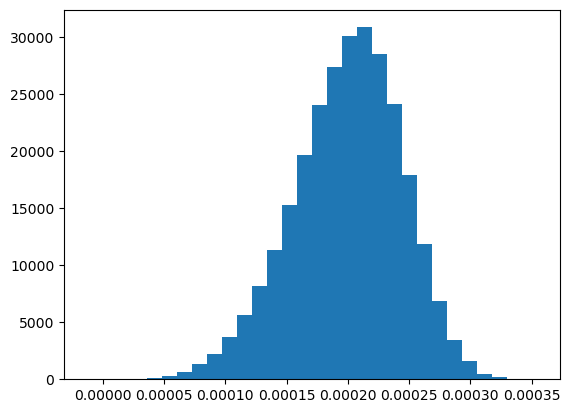

In [7]:
plt.hist(point_driv_continuousW_model3, bins=30)

In [5]:
# Binary W (Full Set)
est_driv_binaryW_model1 = ForestDRIV(projection=False, discrete_treatment=True, discrete_instrument=False, 
                                     n_estimators=5000, min_samples_leaf=100, max_samples=0.02, 
                                     random_state=309, cov_clip = 0.1, n_jobs=15) 
est_driv_binaryW_model1.fit(Y_model1_mat, W_model1_mat_binary, Z=Z_model1_mat, X=X_model1_mat, cache_values=True)
point_driv_binaryW_model1 = est_driv_binaryW_model1.effect(X_model1_mat)
print(pd.DataFrame({"dat": point_driv_binaryW_model1}).describe())

                 dat
count  320236.000000
mean       -0.105385
std         0.015733
min        -0.160663
25%        -0.116629
50%        -0.103409
75%        -0.093545
max        -0.053157


In [6]:
# Binary W (Full Set)
est_driv_binaryW_model2 = ForestDRIV(projection=False, discrete_treatment=True, discrete_instrument=False,
                                     n_estimators=5000, min_samples_leaf=100, max_samples=0.02, 
                                     random_state=309, cov_clip = 0.1, n_jobs=15) 
est_driv_binaryW_model2.fit(Y_model2_mat, W_model2_mat_binary, Z=Z_model2_mat, X=X_model2_mat, cache_values=True)
point_driv_binaryW_model2 = est_driv_binaryW_model2.effect(X_model2_mat)
print(pd.DataFrame({"dat": point_driv_binaryW_model2}).describe())

                 dat
count  293038.000000
mean       -0.036041
std         0.006110
min        -0.060008
25%        -0.040186
50%        -0.036246
75%        -0.032161
max        -0.001960


In [21]:
# Binary W (Full Set)
est_driv_binaryW_model3 = ForestDRIV(projection=False, discrete_treatment=True, discrete_instrument=False, \
                                         n_estimators=5000, min_samples_leaf=200, max_samples=0.02, 
                                         random_state=309, cov_clip = 0.1, n_jobs=15) 
est_driv_binaryW_model3.fit(Y_model3_mat, W_model3_mat_binary, Z=Z_model3_mat, X=X_model3_mat, cache_values=True)
point_driv_binaryW_model3 = est_driv_binaryW_model3.effect(X_model3_mat)
print(pd.DataFrame({"dat": point_driv_binaryW_model3}).describe())

                 dat
count  276054.000000
mean       -0.016112
std         0.004961
min        -0.032103
25%        -0.019814
50%        -0.016362
75%        -0.012646
max         0.003171


(array([7.0000e+00, 3.3000e+01, 1.6600e+02, 5.6200e+02, 1.6300e+03,
        3.6500e+03, 6.9730e+03, 1.1206e+04, 1.5696e+04, 1.9365e+04,
        2.2225e+04, 2.3579e+04, 2.3708e+04, 2.3673e+04, 2.2869e+04,
        2.1093e+04, 1.8814e+04, 1.6260e+04, 1.3279e+04, 1.0505e+04,
        7.9020e+03, 5.3640e+03, 3.5460e+03, 2.0070e+03, 1.1150e+03,
        5.1400e+02, 2.1800e+02, 7.8000e+01, 1.2000e+01, 5.0000e+00]),
 array([-0.03210273, -0.03092695, -0.02975117, -0.02857539, -0.0273996 ,
        -0.02622382, -0.02504804, -0.02387226, -0.02269648, -0.0215207 ,
        -0.02034492, -0.01916913, -0.01799335, -0.01681757, -0.01564179,
        -0.01446601, -0.01329023, -0.01211444, -0.01093866, -0.00976288,
        -0.0085871 , -0.00741132, -0.00623554, -0.00505975, -0.00388397,
        -0.00270819, -0.00153241, -0.00035663,  0.00081915,  0.00199493,
         0.00317072]),
 <BarContainer object of 30 artists>)

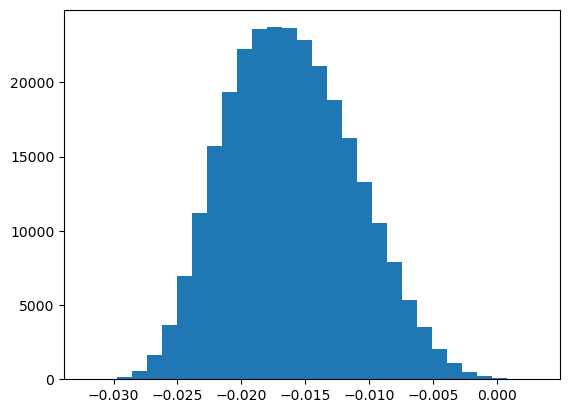

In [23]:
plt.hist(point_driv_binaryW_model3, bins=30)

In [ ]:
point_driv_lb_continuousW_model1, point_driv_ub_continuousW_model1 = est_driv_continuousW_model1.effect_interval(X_model1_mat, alpha=0.05) # type: ignore
z_value_driv_continuousW_model1 = point_driv_continuousW_model1/((point_driv_ub_continuousW_model1-point_driv_lb_continuousW_model1)/(2*1.96))
p_value_driv_continuousW_model1 = scipy.stats.norm.sf(abs(z_value_driv_continuousW_model1)) # * 2
p_value_BH_driv_continuousW_model1 = multipletests(pvals = p_value_driv_continuousW_model1, method = "fdr_bh", alpha=0.1)

full_results_continuousW_model1 = pd.DataFrame({"IID": selected_id_set1_arr, "point": point_driv_continuousW_model1, "upper_bound": point_driv_ub_continuousW_model1, \
                                "lower_bound": point_driv_lb_continuousW_model1, "z-value": z_value_driv_continuousW_model1, \
                                "p_value": p_value_driv_continuousW_model1, "p_value_corrected": p_value_BH_driv_continuousW_model1[1]})

# model 2
point_driv_lb_continuousW_model2, point_driv_ub_continuousW_model2 = est_driv_continuousW_model2.effect_interval(X_model2_mat, alpha=0.05) # type: ignore
z_value_driv_continuousW_model2 = point_driv_continuousW_model2/((point_driv_ub_continuousW_model2-point_driv_lb_continuousW_model2)/(2*1.96))
p_value_driv_continuousW_model2 = scipy.stats.norm.sf(abs(z_value_driv_continuousW_model2)) # * 2
p_value_BH_driv_continuousW_model2 = multipletests(pvals = p_value_driv_continuousW_model2, method = "fdr_bh", alpha=0.1)

full_results_continuousW_model2 = pd.DataFrame({"IID": selected_id_set2_arr, "point": point_driv_continuousW_model2, "upper_bound": point_driv_ub_continuousW_model2, \
                                "lower_bound": point_driv_lb_continuousW_model2, "z-value": z_value_driv_continuousW_model2, \
                                "p_value": p_value_driv_continuousW_model2, "p_value_corrected": p_value_BH_driv_continuousW_model2[1]})

# model 3
point_driv_lb_continuousW_model3, point_driv_ub_continuousW_model3 = est_driv_continuousW_model3.effect_interval(X_model3_mat, alpha=0.05) # type: ignore
z_value_driv_continuousW_model3 = point_driv_continuousW_model3/((point_driv_ub_continuousW_model3-point_driv_lb_continuousW_model3)/(2*1.96))
p_value_driv_continuousW_model3 = scipy.stats.norm.sf(abs(z_value_driv_continuousW_model3)) # * 2
p_value_BH_driv_continuousW_model3 = multipletests(pvals = p_value_driv_continuousW_model3, method = "fdr_bh", alpha=0.1)

full_results_continuousW_model3 = pd.DataFrame({"IID": selected_id_set3_arr, "point": point_driv_continuousW_model3, "upper_bound": point_driv_ub_continuousW_model3, \
                                "lower_bound": point_driv_lb_continuousW_model3, "z-value": z_value_driv_continuousW_model3, \
                                "p_value": p_value_driv_continuousW_model3, "p_value_corrected": p_value_BH_driv_continuousW_model3[1]})


In [ ]:
full_results_continuousW_model3.describe()

In [ ]:
point_driv_lb_binaryW_model1, point_driv_ub_binaryW_model1 = est_driv_binaryW_model1.effect_interval(X_model1_mat, alpha=0.05) # type: ignore
z_value_driv_binaryW_model1 = point_driv_binaryW_model1/((point_driv_ub_binaryW_model1-point_driv_lb_binaryW_model1)/(2*1.96))
p_value_driv_binaryW_model1 = scipy.stats.norm.sf(abs(z_value_driv_binaryW_model1)) # * 2
p_value_BH_driv_binaryW_model1 = multipletests(pvals = p_value_driv_binaryW_model1, method = "fdr_bh", alpha=0.1)

full_results_binaryW_model1 = pd.DataFrame({"IID": selected_id_set1_arr, "point": point_driv_binaryW_model1, "upper_bound": point_driv_ub_binaryW_model1, \
                                "lower_bound": point_driv_lb_binaryW_model1, "z-value": z_value_driv_binaryW_model1, \
                                "p_value": p_value_driv_binaryW_model1, "p_value_corrected": p_value_BH_driv_binaryW_model1[1]})

# model 2
point_driv_lb_binaryW_model2, point_driv_ub_binaryW_model2 = est_driv_binaryW_model2.effect_interval(X_model2_mat, alpha=0.05) # type: ignore
z_value_driv_binaryW_model2 = point_driv_binaryW_model2/((point_driv_ub_binaryW_model2-point_driv_lb_binaryW_model2)/(2*1.96))
p_value_driv_binaryW_model2 = scipy.stats.norm.sf(abs(z_value_driv_binaryW_model2)) # * 2
p_value_BH_driv_binaryW_model2 = multipletests(pvals = p_value_driv_binaryW_model2, method = "fdr_bh", alpha=0.1)

full_results_binaryW_model2 = pd.DataFrame({"IID": selected_id_set2_arr, "point": point_driv_binaryW_model2, "upper_bound": point_driv_ub_binaryW_model2, \
                                "lower_bound": point_driv_lb_binaryW_model2, "z-value": z_value_driv_binaryW_model2, \
                                "p_value": p_value_driv_binaryW_model2, "p_value_corrected": p_value_BH_driv_binaryW_model2[1]})

# model 3
point_driv_lb_binaryW_model3, point_driv_ub_binaryW_model3 = est_driv_binaryW_model3.effect_interval(X_model3_mat, alpha=0.05) # type: ignore
z_value_driv_binaryW_model3 = point_driv_binaryW_model3/((point_driv_ub_binaryW_model3-point_driv_lb_binaryW_model3)/(2*1.96))
p_value_driv_binaryW_model3 = scipy.stats.norm.sf(abs(z_value_driv_binaryW_model3)) # * 2
p_value_BH_driv_binaryW_model3 = multipletests(pvals = p_value_driv_binaryW_model3, method = "fdr_bh", alpha=0.1)

full_results_binaryW_model3 = pd.DataFrame({"IID": selected_id_set3_arr, "point": point_driv_binaryW_model3, "upper_bound": point_driv_ub_binaryW_model3, \
                                "lower_bound": point_driv_lb_binaryW_model3, "z-value": z_value_driv_binaryW_model3, \
                                "p_value": p_value_driv_binaryW_model3, "p_value_corrected": p_value_BH_driv_binaryW_model3[1]})


In [ ]:
full_results_binaryW_model1.describe()

In [ ]:
shap_values_driv_binaryW_model1 = est_driv_binaryW_model1.shap_values(X_model1_mat)